# [E-15]License Plate OCR

- 차로 이동을 할 때 주차장을 자주 이용하는 데 요즘 많은 주차장이 OCR을 이용해서 관리를 한다.
- 카메라로 찍고 거의 바로 자동차 번호판을 인식해서 출력을 해 주는 데, 궁금해졌다.
- 다른 나라는 어떻게 할까??

<br>

#### 📌 [OS 사용법](http://pythonstudy.xyz/python/article/507-%ED%8C%8C%EC%9D%BC%EA%B3%BC-%EB%94%94%EB%A0%89%ED%86%A0%EB%A6%AC)

#### 📌 [os.listdir()](https://m.blog.naver.com/hankrah/221755651815)

## Step 1. 검증용 데이터셋 준비

In [1]:
import os

img_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'

license_plate = os.listdir(img_dir)
license_plate

['quebec.jpeg',
 'southdakota.jpeg',
 'manitoba.jpeg',
 'northwest.jpeg',
 'connecticut.jpeg',
 'guam.jpeg',
 'hawaii.jpeg']

In [2]:
os.getcwd()

'/aiffel/aiffel/ocr_python'

.ipynb_checkpoints 삭제하기

In [3]:
! rm -rf `find -type d -name .ipynb_checkpoints`

## Step 2 keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

### 문자 검출 과정

---

**Text Detection(문자검출)** 

- **입력받은 사진 속에서 문자의 위치를 찾아내는 과정**

**Text Recognition(문자인식)**

- **찾은 문자 영역으로부터 문자를 읽어내는 것**

<br>

### 2.1 Google OCR API

#### **STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.**


```
$ pip install --upgrade google-api-python-client
$ pip install google-cloud-vision
```

#### **STEP 2) Google Cloud Vision API 사용**

**아래 링크의 설명을 참고하여 서비스 계정 및 인증키를 생성합니다.  
브라우저에서 다운로드한 인증키는 `my_google_api_key.json`이라는 파일명으로 변경합시다. (파일은 프로젝트 이름으로 시작하는 파일명으로 자동 저장됩니다.)**

- **[Google Cloud Vision API 키 생성 및 저장하기](https://kimchangheon.tistory.com/166)**

**`cloud jupyter`를 열고 `my_google_api_key.json` 파일을 `~/aiffel/ocr_python` 디렉터리에 업로드**

In [4]:
# API 사용 함수
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [5]:
# OCR API 
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
for plate in license_plate:
    print(plate)
    path = os.path.join(img_dir, plate)
    
    # 위에서 정의한 OCR API 이용 함수를 호출
    detect_text(path)

quebec.jpeg
Texts:

"Québec
M13 AMA
Je me souviens-
"

"Québec"

"M13"

"AMA"

"Je"

"me"

"souviens-"
bounds: (304,267),(536,265),(536,301),(304,303)
southdakota.jpeg
Texts:

"Supaladkitos
1AE D24
GREAT FACES. GREAT PLACES.
5
2012
1AED24
"

"Supaladkitos"

"1AE"

"D24"

"GREAT"

"FACES."

"GREAT"

"PLACES."

"5"

"2012"

"1AED24"
bounds: (629,299),(629,273),(638,273),(638,299)
manitoba.jpeg
Texts:

"Frindly Manitoba
EGM 451'
SEP
2010
A 24456749
"

"Frindly"

"Manitoba"

"EGM"

"451'"

"SEP"

"2010"

"A"

"24456749"
bounds: (571,294),(616,292),(616,302),(572,304)
northwest.jpeg
Texts:

"SPECTACULAR
PLACE
STICKER
HERE
300101
NORTHWEST TERRITORIES
"

"SPECTACULAR"

"PLACE"

"STICKER"

"HERE"

"300101"

"NORTHWEST"

"TERRITORIES"
bounds: (280,228),(495,230),(495,263),(280,261)
connecticut.jpeg
Texts:

"Connecticut
409-XWE
Constitution State
"

"Connecticut"

"409-XWE"

"Constitution"

"State"
bounds: (407,269),(492,270),(492,300),(407,299)
guam.jpeg
Texts:

"GUAM U.S.A.
DEC12
112062
TU250

### 2.2 keras-ocr
---

- **텐서플로우의 케라스 API를 기반**
- **이미지 속 문자를 읽는 End-to-End OCR을 가능**
- **검출 모델로 CRAFT(Character Region Awareness for Text Detection)를 사용**
- **인식 모델로 CRNN을 사용**

**`keras-ocr` 버전을 클라우드 쉘에서 확인**

```
$ pip list | grep keras-ocr
```

**필요한 라이브러리인 `keras_ocr` 과 인식 결과의 시각화를 위한 `matplotlib.pyplot` 를 불러옵니다.  
`keras_ocr.pipeline.Pipeline()` 는 인식을 위한 파이프라인을 생성하는데   
이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 됩니다.  
`검출기와 인식기`를 위한 가중치 하나씩을 불러오겠지요.**

- **[keras_ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)**


In [6]:
# 라이브러리 불러오기
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
# 이미지 경로 설정, 가져오기
images = [keras_ocr.tools.read(os.path.join(img_dir, plate)) for plate in license_plate]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, plate)]) for plate in license_plate]

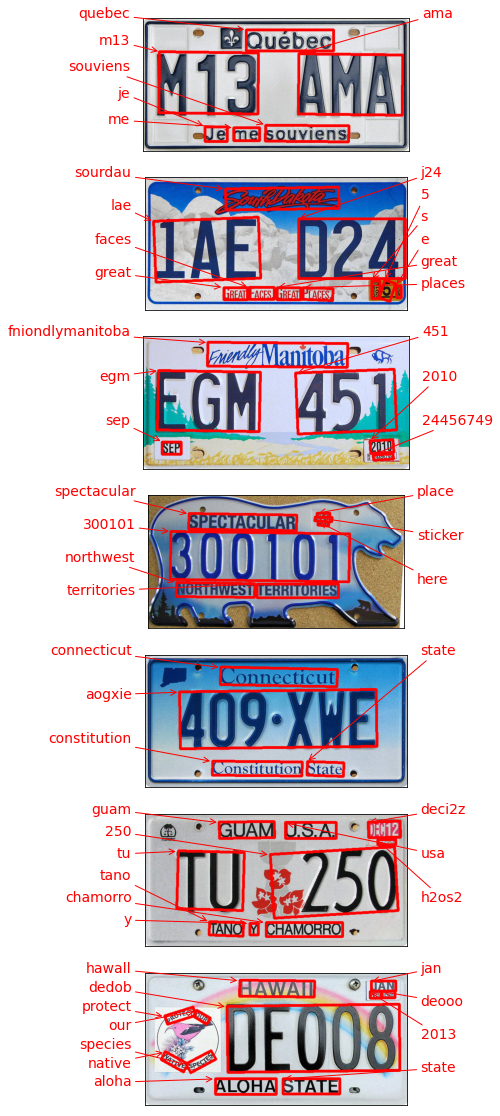

In [8]:
# pyplot으로 시각화
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 테서랙트

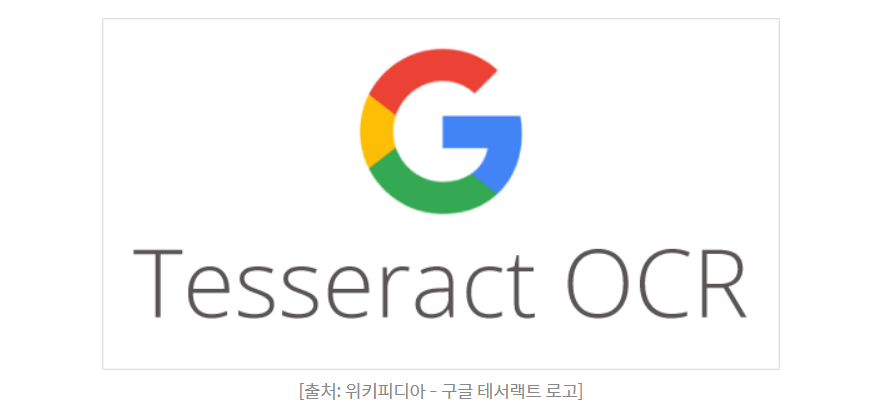

**테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식**

- **구글에서 후원하는 OCR 오픈소스 라이브러리**
- **현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용**
- **버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원**

**오픈소스라는 점은 여러분들이 원하는 프로젝트에 활용하기 쉽다는 것을 뜻하니,  
직접 해 보면서 익혀두면 나중에 간단한 OCR 모델이 필요할 때 빠르게 활용할 수 있을 겁니다.**

<br>

### **1) 테서랙트 설치하기**

---


```
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

<br>

### **2) 테서랙트 파이썬 wrapper 설치하기**

---

**`Pytesseract`는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)입니다.  
파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.**

- **[Pytesseract](https://pypi.org/project/pytesseract/)**
- **[위키백과: 래퍼 라이브러리](https://ko.wikipedia.org/wiki/%EB%9E%98%ED%8D%BC_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC)**

<br>

**클라우드 컨테이너에는 이미 설치가 되어 있습니다. 아래 명령어로 확인할 수 있어요.**

```
 pip list | grep pytesseract
```

<br>

### **3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)**

---

**한 번에 이미지 내의 문자 검출과 인식 가능**

**OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 시행**

<br>

**`crop_word_regions()` 함수**

- **선택한 테스트 이미지를 받아서, 
문자 검출을 진행한 후, 
검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수**

<br>

**`pytesseract.image_to_data()` 를 사용**

- **파이썬에서 편하게 사용하기 위해   
`pytesseract` 의 `Output` 을 사용해서 결괏값의 형식을 딕셔너리(`DICT`) 형식으로 설정  
인식된 결과는 바운딩 박스의 left, top, width, height 정보를 보유  
바운딩 박스를 사용해 이미지의 문자 영역들을  
파이썬 `PIL(pillow)` 또는 `opencv` 라이브러리를 사용해 잘라(crop)서 `cropped_image_path_list`에 담아 리턴**

**(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상 동작하게 됩니다.**

```
 sudo apt install tesseract-ocr-kor
```

**언어팩 설치 관련해서는 이 [페이지](http://blog.daum.net/rayolla/1141)를 참고해 주세요.**

<br>

### **4) 테서랙트로 잘린 이미지에서 단어 인식하기**

---

**문자 인식**

- **검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 
영역별 텍스트가 결괏값으로 나오는 `image_to_string()`를 사용**

**인식된 결과가 실제 이미지와 맞는지 확인**


In [9]:
# 테서랙트로 문자 검출하고 이미지 자르기 (detection)
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    
    print()
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done\n")

In [10]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images/'

for plate in license_plate:
    img_file_path = work_dir + plate   #테스트용 이미지 경로
    print(plate + "\n")
    crop_recognize_images(img_file_path, work_dir)

quebec.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png

eS

Ea Quebec

c=

“13

AM i

@Je

‘rie

SOUVIECNSe


Done

southdakota.jpeg

/aiffel/aiffel/ocr_python/images/0000.png

INE O24

Done

manitoba.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/i

## Step 3.  테스트 결과 정리

quebec.jpeg
Google OCR API
Texts:

"Québec
M13 AMA
Je me souviens-
"

"Québec"

"M13"

"AMA"

"Je"

"me"

"souviens-"
bounds: (304,267),(536,265),(536,301),(304,303)

Keras OCR


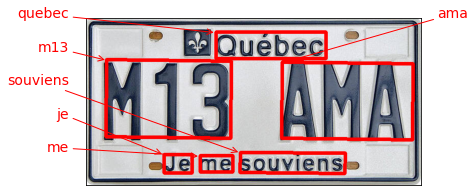


Tesseract
quebec.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png

eS

Ea Quebec

c=

“13

AM i

@Je

‘rie

SOUVIECNSe


Done

southdakota.jpeg
Google OCR API
Texts:

"Supaladkitos
1AE D24
GREAT FACES. GREAT PLACES.
5
2012
1AED24
"

"Supaladkitos"

"1AE"

"D24"

"GREAT"

"FACES."

"GREAT"

"PLACES."

"5"

"2012"

"1AED24"
bounds: (629,299),(629,273),(638,273),(638,299)

Keras OCR


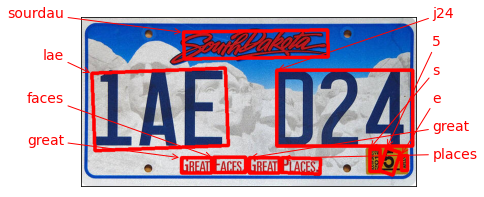


Tesseract
southdakota.jpeg

/aiffel/aiffel/ocr_python/images/0000.png

INE O24

Done

manitoba.jpeg
Google OCR API
Texts:

"Frindly Manitoba
EGM 451'
SEP
2010
A 24456749
"

"Frindly"

"Manitoba"

"EGM"

"451'"

"SEP"

"2010"

"A"

"24456749"
bounds: (571,294),(616,292),(616,302),(572,304)

Keras OCR


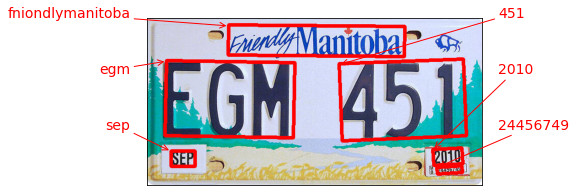


Tesseract
manitoba.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/images/0010.png
/aiffel/aiffel/ocr_python/images/0011.png
/aiffel/aiffel/ocr_python/images/0012.png

~y

pug Manitoba ~

EB;

GM

4h]

SEP

:

Pde ae

!

é-

aan

>|


Done

northwest.jpeg
Google OCR API
Texts:

"SPECTACULAR
PLACE
STICKER
HERE
300101
NORTHWEST TERRITORIES
"

"SPECTACULAR"

"PLACE"

"STICKER"

"HERE"

"300101"

"NORTHWEST"

"TERRITORIES"
bounds: (280,228),(495,230),(495,263),(280,261)

Keras OCR


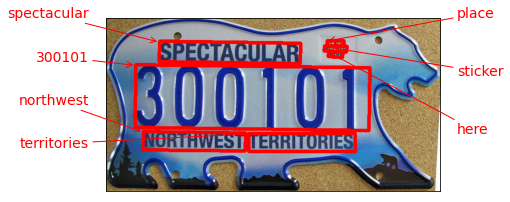


Tesseract
northwest.jpeg

/aiffel/aiffel/ocr_python/images/0000.png


Done

connecticut.jpeg
Google OCR API
Texts:

"Connecticut
409-XWE
Constitution State
"

"Connecticut"

"409-XWE"

"Constitution"

"State"
bounds: (407,269),(492,270),(492,300),(407,299)

Keras OCR


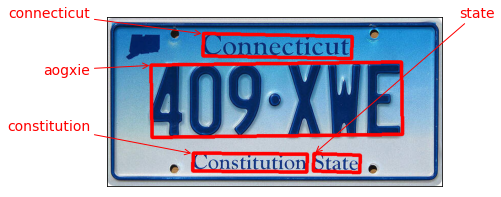


Tesseract
connecticut.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png


(Connecticut

AN9-X WE

|

©

Constitution

State

~

Done

guam.jpeg
Google OCR API
Texts:

"GUAM U.S.A.
DEC12
112062
TU250
**
TANO Y CHAMORRO
"

"GUAM"

"U.S.A."

"DEC12"

"112062"

"TU250"

"**"

"TANO"

"Y"

"CHAMORRO"
bounds: (303,275),(489,275),(489,304),(303,304)

Keras OCR


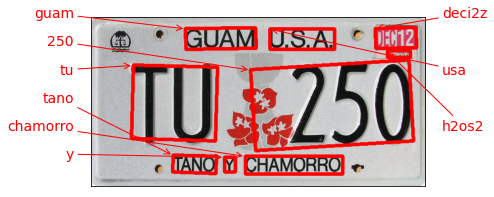


Tesseract
guam.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/images/0010.png
/aiffel/aiffel/ocr_python/images/0011.png

(*)

e

(ZUAM

IS. A

a

Tioo8D

TU 2.750

¢

TANO

VY

CHAMORRO

7

Done

hawaii.jpeg
Google OCR API
Texts:

"HAWAII
JAN
2013 DE008
DE008
OUR
PROTECT
NATIVE
SPECIES
ALOHA STATE
"

"HAWAII"

"JAN"

"2013"

"DE008"

"DE008"

"OUR"

"PROTECT"

"NATIVE"

"SPECIES"

"ALOHA"

"STATE"
bounds: (344,267),(482,267),(482,300),(344,300)

Keras OCR


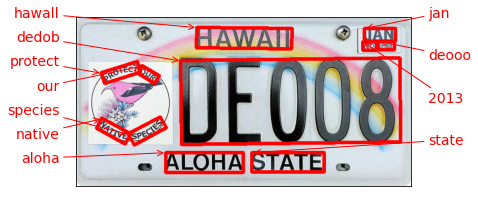


Tesseract
hawaii.jpeg

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png

Be DEO 0 8

Ce

ALOHA

STATE

Done



In [11]:
for plate in license_plate:
    print(plate)
    print("Google OCR API")
    path = os.path.join(img_dir, plate)    
    detect_text(path)
    
    print("\nKeras OCR")
    idx = license_plate.index(plate)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    
    print("\nTesseract")
    img_file_path = work_dir + plate   #테스트용 이미지 경로
    print(plate + "\n")
    crop_recognize_images(img_file_path, work_dir)
    

## Step4. 결과 분석과 결론 제시

- 결과적으로 보면 Google OCR API의 성능이 가장 좋은 것 같다.
    - hawaii번호판
        - `Google OCR API`는 모든 문자를 다 잘 파악해서 출력
        -` Keras-ocr`은 'DE008' 중앙에 있는 문자를 'dedob'로 출력
            - 큰 글자임에도 틀리게 인식..이건 무엇이 문제일까?
        - `Tesseract`는 영역지정을 잘못했나?? 제일 결과가 좋지 않다.

<br>

- 근데 `이용료를 지불`해야 하니 Keras OCR을 좀 더 잘 이용하면 좋을 것 같다.

<br>

- 우리나라 번호판은 다른 나라 번호판에 비해 아주 단조로와 한글 인식만 제대로 한다면 바로 활용할 수 있을 것 같다.
- Tesseract의 결과가 좋지 않을 것을 보면 활용을 잘 못 한 것이 아닐까?? 싶기도 하다.
    - 모듈을 설정할 때 여러가지가 있던 데. 그냥 주어진 것으로 해서...
    - 정확히 어떤 성능이 있는 지 설명이 있었으면 좋았을 것 같다.
- 그림에서 문자를 인식하는 것은 많은 활용도가 있을 것 같다.

##  회고

1. 이번 프로젝트에서 **어려웠던 점**
- 여러 가지 이미지를 한 번에 활용하려고 하니, os에 대한 이해도가 많이 필요했다.
2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- **알아낸 점**
    - os에 대한 것을 조금 알게됐다.
- **아직 모호한 점**
    - Tesseract에서 모듈의 사용방법을 좀 더 자세히 알 수 있다면 좋을 듯..
    - 컴퓨터가 책을 읽어 주는 것은 어떻게 하는 지 쪼매 궁금함...
    - Tesseract에서 이미지를 생성하는 데, 이미지가 들어오면 새로운 디렉토리를 만들어서 이미지를 저장하고 싶었으나.. 아직은...    